In [41]:
from bullet import SimImage
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

TEXTURE_PATH = "textures/texture.jpg"
LINE_SAVE_PATH = "line_images/"

line_dataset_size = 1

In [2]:
# Create Simulation
sim = SimImage(texture_path=TEXTURE_PATH)

In [40]:
# Line Generate Loop
for i in range(line_dataset_size):
    # Get an image + waypoints
    img_raw, waypoints = sim.generate_line_images()
    
    # Save image
    img_rgb = Image.fromarray(img_raw[:, :, :3])
    img_rgb.save(f'{LINE_SAVE_PATH}images/line_image_{i}.jpeg')

    # Save mask
    img_alpha = img_raw[:, :, 3]
    img_blank = np.expand_dims(img_alpha, axis=-1)
    img_blank = np.repeat(img_blank, 3, axis=-1)
    mask = np.all(img_raw[:, :, :3] != img_blank, axis=-1)
    mask_img = Image.fromarray(mask)
    mask_img.save(f'{LINE_SAVE_PATH}masks/mask_image_{i}.jpeg')

    # 
    with open(f'{LINE_SAVE_PATH}labels/point_label_{i}.txt', 'w') as f:
        f.write(str(waypoints[:6]))
    f.close()

[[0, 0, 0], [-0.25, 0.0, 0.0], [-0.49620193825305203, -0.04341204441673258, 0.0], [-0.7424038765061041, -0.08682408883346517, 0.0], [-0.9886058147591561, -0.13023613325019776, 0.0], [-1.2348077530122081, -0.17364817766693033, 0.0], [-1.4810096912652602, -0.2170602220836629, 0.0], [-1.7272116295183122, -0.2604722665003955, 0.0], [-1.9734135677713642, -0.3038843109171281, 0.0], [-2.2196155060244163, -0.34729635533386066, 0.0], [-2.4573796350982047, -0.2700421067401238, 0.0], [-2.695143764171993, -0.19278785814638694, 0.0], [-2.941345702425045, -0.2361999025631195, 0.0], [-3.1875476406780967, -0.2796119469798521, 0.0], [-3.4337495789311485, -0.32302399139658466, 0.0], [-3.6799515171842003, -0.36643603581331724, 0.0], [-3.862789942588993, -0.19593644579769262, 0.0], [-4.0456283679937854, -0.025436855782068002, 0.0], [-4.228466793398578, -0.19593644579769262, 0.0], [-4.411305218803371, -0.36643603581331724, 0.0]]
(256, 256)


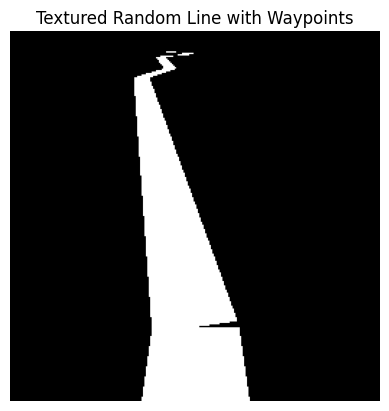

In [39]:
# Generate image and waypoints
img, waypoints = sim.generate_line_images()

# Print waypoints
print(waypoints)

img_alpha = img[:, :, 3]
img_blank = np.expand_dims(img_alpha, axis=-1)
img_blank = np.repeat(img_blank, 3, axis=-1)
mask = np.all(img[:, :, :3] != img_blank, axis=-1)
print(mask.shape)
# Display image
plt.imshow(mask, cmap='gray')
plt.title('Textured Random Line with Waypoints')
plt.axis('off')
plt.show()